In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 0
np.random.seed(random_seed)

In [2]:
def get_num_lines(path):
    with open(path) as f:
        for i, _ in enumerate(f):
            pass
    return i+1

## Business

In [3]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_business.json")
data_business = pd.read_json(file_path, lines=True, nrows=10000)  # 150346 x 14
display(data_business.head(2), data_business.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


(10000, 14)

In [4]:
(get_num_lines(file_path), data_business.shape[1])

(150346, 14)

## Users

In [5]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_user.json")
data_users = pd.read_json(file_path, lines=True, nrows=10000)  # 1987897 x 22
display(data_users.head(2), data_users.shape)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946


(10000, 22)

In [6]:
(get_num_lines(file_path), data_users.shape[1])

(1987897, 22)

## Checkin

In [7]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_checkin.json")
data_checkin = pd.read_json(file_path, lines=True, nrows=10000)  # 131930 x 2
display(data_checkin.head(2), data_checkin.shape)

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."


(10000, 2)

In [8]:
(get_num_lines(file_path), data_checkin.shape[1])

(131930, 2)

## Review

In [9]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=10000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


(10000, 9)

In [10]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

## Tip

In [11]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_tip.json")
data_tip = pd.read_json(file_path, lines=True, nrows=10000)  # 908915 x 5
display(data_tip.head(2), data_tip.shape)

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0


(10000, 5)

In [12]:
(get_num_lines(file_path), data_tip.shape[1])

(908915, 5)

---
---

## Review

In [13]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=1000000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


(1000000, 9)

In [14]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

### Regardons plus en détails les variables du jeu de données

In [15]:
data_review.describe(exclude=['number','datetime']).T

,count,unique,top,freq
review_id,1000000,1000000,KU_O5udG6zpxOg-VcAEodg,1
user_id,1000000,542003,_BcWyKQL16ndpBdggh2kNA,483
business_id,1000000,27095,GBTPC53ZrG1ZBY3DT8Mbcw,4661
text,1000000,998357,I have eaten at just about every decent Indian...,5


In [16]:
data_review.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
stars,1000000.0,3.783959,1.0,3.0,4.0,5.0,5.0,1.440197
useful,1000000.0,1.106594,0.0,0.0,0.0,1.0,539.0,2.848906
funny,1000000.0,0.307812,0.0,0.0,0.0,0.0,284.0,1.428185
cool,1000000.0,0.457129,0.0,0.0,0.0,0.0,172.0,1.799114
date,1000000,2016-07-13 10:09:02.464016128,2005-03-01 17:47:15,2014-08-07 16:29:16.500000,2016-10-11 16:02:42,2018-09-01 01:26:22.249999872,2022-01-19 19:47:59,NaN


### Affichons la répartition des notes de review

In [17]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    
    if show_values:
        ax.bar_label(ax.containers[0])
        
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

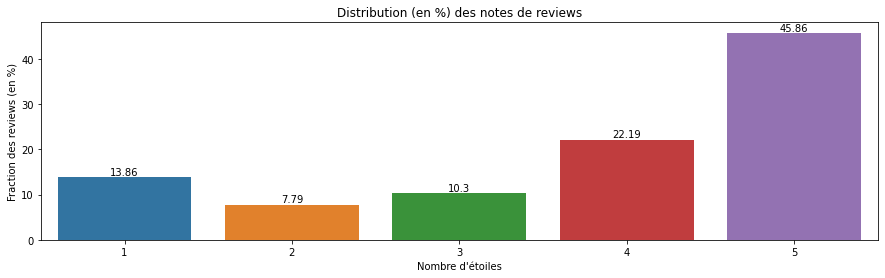

In [18]:
select = pd.DataFrame(data_review.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

### Binarisation des reviews

In [19]:
data_review['is_low'] = data_review.stars < 3 # TRUE with 1,2 stars and FALSE with 3,4,5 stars
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,is_low
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,False
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,False


(1000000, 10)

### Sélectionnons au hasard des reviews dont les notes sont 1 ou 2

In [20]:
sample_size = 10000

In [21]:
# Select samples with the original dataset stars' ratio
data_bad_reviews = data_review[data_review.is_low == True].sample(sample_size, random_state=random_seed)[['stars', 'text']].reset_index(drop=True)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,1,They do not care about customers. My online o...
1,1,Food is gross and service is about as bad. Tri...


(10000, 2)

### Affichons la distribution des scores dans le nouveau dataset

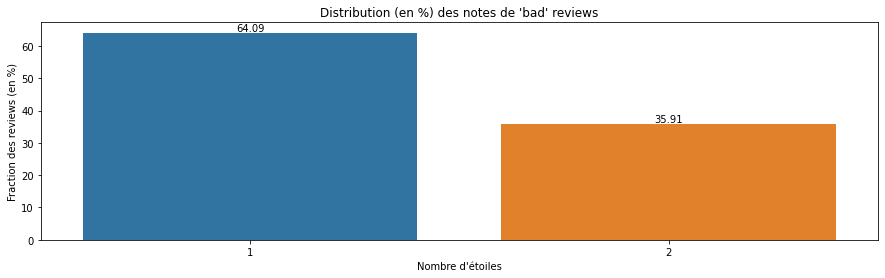

In [22]:
select = pd.DataFrame(data_bad_reviews.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

### Sauvegardons le nouveau dataset des mauvaises reviews

In [23]:
data_bad_reviews.to_csv("data/export_bad_reviews.csv", index=False)

In [88]:
import spacy
from collections import Counter

In [89]:
nlp = spacy.load('en_core_web_sm')

In [90]:
#text1 = """Most of the outlay will be at home. No surprise there, either. While Samsung has expanded overseas, South Korea is still host to most of its factories and research engineers. """
text1 = "Hello World! The world is a wonderful place :)"

In [104]:
#text2 = """Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and statistical natural language processing (NLP) for English written in the Python programming language. It was developed by Steven Bird and Edward Loper in the Department of Computer and Information Science at the University of Pennsylvania."""
text2 = "The woman ran to the shore... saw two women playing in waves and said Hello world"

In [105]:
texts = [text1, text2]
texts

['Hello World! The world is a wonderful place :)',
 'The woman ran to the shore... saw two women playing in waves and said Hello world']

In [129]:
merged = []

for text in texts:
    doc = nlp(text)
    #remove stopwords and punctuations
    words = [token for token in doc if token.is_stop != True and token.is_punct != True]
    words_l = [token.lemma_ for token in words]
    print(words_l)
    # word_freq = Counter(words_l)
    # common_words = word_freq # .most_common(5)
    # print (common_words)
    
    merged.extend(words_l)
    print("")
    
merged
word_freq = Counter(merged)
common_words = word_freq # .most_common(5)
print (common_words)

['hello', 'World', 'world', 'wonderful', 'place']

['woman', 'run', 'shore', 'see', 'woman', 'play', 'wave', 'say', 'hello', 'world']

Counter({'hello': 2, 'world': 2, 'woman': 2, 'World': 1, 'wonderful': 1, 'place': 1, 'run': 1, 'shore': 1, 'see': 1, 'play': 1, 'wave': 1, 'say': 1})


In [158]:
" | ".join(nlp.Defaults.stop_words)

"thereupon | fifty | down | what | ‘re | yours | do | my | next | 'd | one | somewhere | whence | whereupon | was | put | could | sometime | anyway | the | anywhere | cannot | yourselves | ‘s | whoever | whither | using | due | hereafter | something | ’ll | anyhow | before | must | nowhere | some | every | amongst | beside | move | you | herein | therein | should | back | across | each | most | take | hence | did | own | anything | myself | unless | but | ours | ourselves | several | first | at | would | other | ten | been | all | had | below | forty | ‘ve | serious | still | two | four | whom | became | is | indeed | rather | within | really | keep | there | while | same | hereupon | thereby | elsewhere | meanwhile | around | quite | are | amount | where | enough | done | nor | anyone | for | further | am | since | make | they | we | nine | only | being | not | of | upon | thus | another | ca | be | never | over | onto | please | former | when | them | 'll | above | which | ’s | then 

In [217]:
all_lemmas = []

for index, row in data_bad_reviews.iterrows():
    
    # suppression des majuscules (normalement la lemmatization le fait un peu plus loin...)
    text = row['text'].lower()
    
    # suppression des espaces au début et à la fin des textes
    text_clean = text.strip()
    
    # tokenisation
    doc = nlp(text_clean)
    
    # suppression des stopwords, de la ponctuation et des espaces
    tokens = [token for token in doc if token.is_stop != True and token.is_punct != True and token.is_space != True]
    
    # lemmatization
    lemmas = [token.lemma_ for token in tokens]
    
    # on les ajoute à la liste globale des mots
    all_lemmas.extend(lemmas)

In [218]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(500)
print (common_lemmas)

[('food', 6016), ('order', 5916), ('time', 5406), ('place', 5208), ('come', 4682), ('go', 4548), ('service', 4501), ('like', 4389), ('good', 4038), ('tell', 4004), ('say', 3609), ('get', 3582), ('ask', 3498), ('wait', 3134), ('$', 3070), ('bad', 2928), ('want', 2654), ('minute', 2572), ('try', 2530), ('look', 2488), ('take', 2395), ('customer', 2301), ('know', 2247), ('leave', 2206), ('day', 2114), ('people', 2050), ('eat', 2021), ('restaurant', 1996), ('table', 1966), ('experience', 1944), ('call', 1931), ('work', 1883), ('pay', 1881), ('need', 1806), ('2', 1797), ('think', 1791), ('well', 1721), ('hour', 1685), ('drink', 1641), ('great', 1575), ('way', 1572), ('give', 1572), ('manager', 1536), ('staff', 1525), ('price', 1521), ('room', 1502), ('find', 1501), ('car', 1443), ('taste', 1424), ('review', 1405), ('thing', 1394), ('new', 1371), ('walk', 1332), ('check', 1324), ('chicken', 1317), ('long', 1311), ('sit', 1301), ('nice', 1252), ('money', 1251), ('3', 1249), ('year', 1237), ('

In [219]:
from wordcloud import WordCloud

In [220]:
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=800, margin=2).generate(" ".join(all_lemmas))

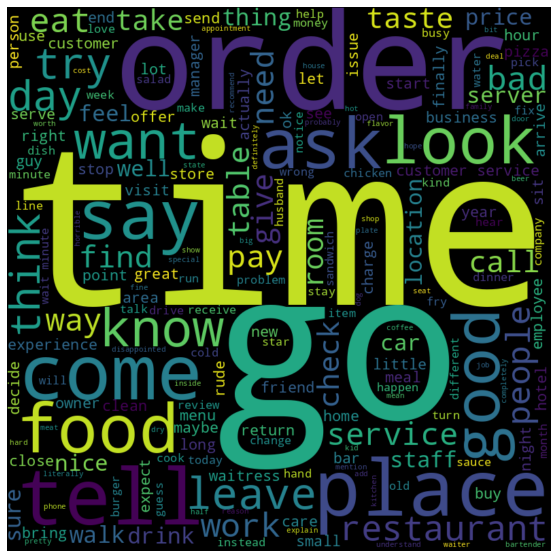

In [221]:
# Display the generated image:
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()